# Advanced Coding Group Project - 2024/25 
#### Students: Michele Turco, Mattia Cervelli, Lorenzo Laterza 

## 0) Import Libraries and the Dataset

Setup your python environment and download the credit-score data

In [28]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the csv file using pandas

credit_card_df = pd.read_csv('train_biased.csv')

## 1) Understanding the dataset



#### 1.1) General overview of the dataset

Using the function .head(), we can extract from the dataset the first x rows (x=5 by default, but we can change this number). They are not useful for analytic purposes, but still enable us to visualize the dataset.

In [14]:
credit_card_df.head

<bound method NDFrame.head of             ID Customer_ID     Month           Name          City  \
0          NaN   CUS_0xd40       NaN  Aaron Maashoh        Lonton   
1       0x1603   CUS_0xd40  February  Aaron Maashoh        Lonton   
2       0x1604   CUS_0xd40       NaN            NaN        Lonton   
3       0x1605   CUS_0xd40     April  Aaron Maashoh        Lonton   
4          NaN   CUS_0xd40       May  Aaron Maashoh        Lonton   
...        ...         ...       ...            ...           ...   
99995  0x25fe9  CUS_0x942c     April          Nicks      BadShire   
99996  0x25fea  CUS_0x942c       May          Nicks      BadShire   
99997  0x25feb         NaN      June          Nicks      BadShire   
99998  0x25fec  CUS_0x942c      July          Nicks  Standhampton   
99999  0x25fed  CUS_0x942c    August          Nicks      BadShire   

              Street    Age          SSN Occupation Annual_Income  ...  \
0      Oxford Street    NaN  821-00-0265    Manager      19114.12  

#### 1.2) Showing the dataset shape

In [15]:
# Identify Number of Columns and Rows
n_rows = len(credit_card_df)
n_columns = len(credit_card_df.columns)
print(f"The dataset contains {n_columns} columns")
print(f"The dataset contains {n_rows} columns")

The dataset contains 27 columns
The dataset contains 100000 columns


#### 1.3) Gathering information from data



In [16]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        90058 non-null   object 
 1   Customer_ID               90107 non-null   object 
 2   Month                     90062 non-null   object 
 3   Name                      81113 non-null   object 
 4   City                      90149 non-null   object 
 5   Street                    90080 non-null   object 
 6   Age                       85512 non-null   float64
 7   SSN                       89999 non-null   object 
 8   Occupation                90056 non-null   object 
 9   Annual_Income             89906 non-null   object 
 10  Monthly_Inhand_Salary     76405 non-null   float64
 11  Num_Bank_Accounts         90167 non-null   float64
 12  Num_Credit_Card           89938 non-null   float64
 13  Interest_Rate             90151 non-null   fl

In [17]:
credit_card_df.nunique()

ID                          90058
Customer_ID                 12500
Month                           8
Name                        10139
City                            4
Street                         31
Age                          1501
SSN                         12501
Occupation                     21
Annual_Income               18438
Monthly_Inhand_Salary       13204
Num_Bank_Accounts             879
Num_Credit_Card              1132
Interest_Rate                1597
Num_of_Loan                   399
Type_of_Loan                 6260
Delay_from_due_date            73
Num_of_Delayed_Payment        684
Changed_Credit_Limit         4314
Num_Credit_Inquiries         1124
Credit_Mix                      4
Outstanding_Debt            13088
Credit_Utilization_Ratio    90025
Credit_History_Age            404
Payment_of_Min_Amount           3
Amount_invested_monthly     81866
Credit_Score                    4
dtype: int64

#### 1.4) Missing values

In [18]:
# Check for missing values

missing_values = credit_card_df.isnull().sum()
missing_values

ID                           9942
Customer_ID                  9893
Month                        9938
Name                        18887
City                         9851
Street                       9920
Age                         14488
SSN                         10001
Occupation                   9944
Annual_Income               10094
Monthly_Inhand_Salary       23595
Num_Bank_Accounts            9833
Num_Credit_Card             10062
Interest_Rate                9849
Num_of_Loan                 10191
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        10067
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

#### 1.5) Data Types Check

In [ ]:
##Selecting numerical features
numerical_data = credit_card_df.select_dtypes(include='number')
#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

#Selecting categoricalfeatures
categorical_data = credit_card_df.select_dtypes(include= 'object')
#append the features of categorical_data to list
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)
print('\n')
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 9 numerical features: 

['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Credit_Score']


There are 18 categorical features: 

['ID', 'Customer_ID', 'Month', 'Name', 'City', 'Street', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly']


In [22]:
credit_card_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85512.0,110.226845,684.907588,-500.000000,24.000000,33.000000,42.000000,8698.000000
Monthly_Inhand_Salary,76405.0,4185.789272,3178.560506,303.645417,1625.023750,3086.683333,5940.317500,15204.633333
Num_Bank_Accounts,90167.0,17.105172,117.728215,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,89938.0,22.449410,129.037233,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,90151.0,72.343923,465.684822,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,90012.0,21.081156,14.862707,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,88102.0,27.846882,193.610843,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,90025.0,32.290967,5.114670,20.100770,28.064418,32.318280,36.502272,50.000000
Credit_Score,100000.0,1.880640,0.683065,0.000000,1.000000,2.000000,2.000000,3.000000


In [24]:
credit_card_df.describe(include="object").T

,count,unique,top,freq
ID,90058,90058,0x25fed,1
Customer_ID,90107,12500,CUS_0x8600,8
Month,90062,8,April,11319
Name,81113,10139,Langep,42
City,90149,4,Standhampton,47744
Street,90080,31,Quality Street,5343
SSN,89999,12501,#F%$D@*&8,5008
Occupation,90056,21,Journalist,17002
Annual_Income,89906,18438,17273.83,15
Num_of_Loan,89809,399,3,12898


#### 1.6) Distribution of numerical variables

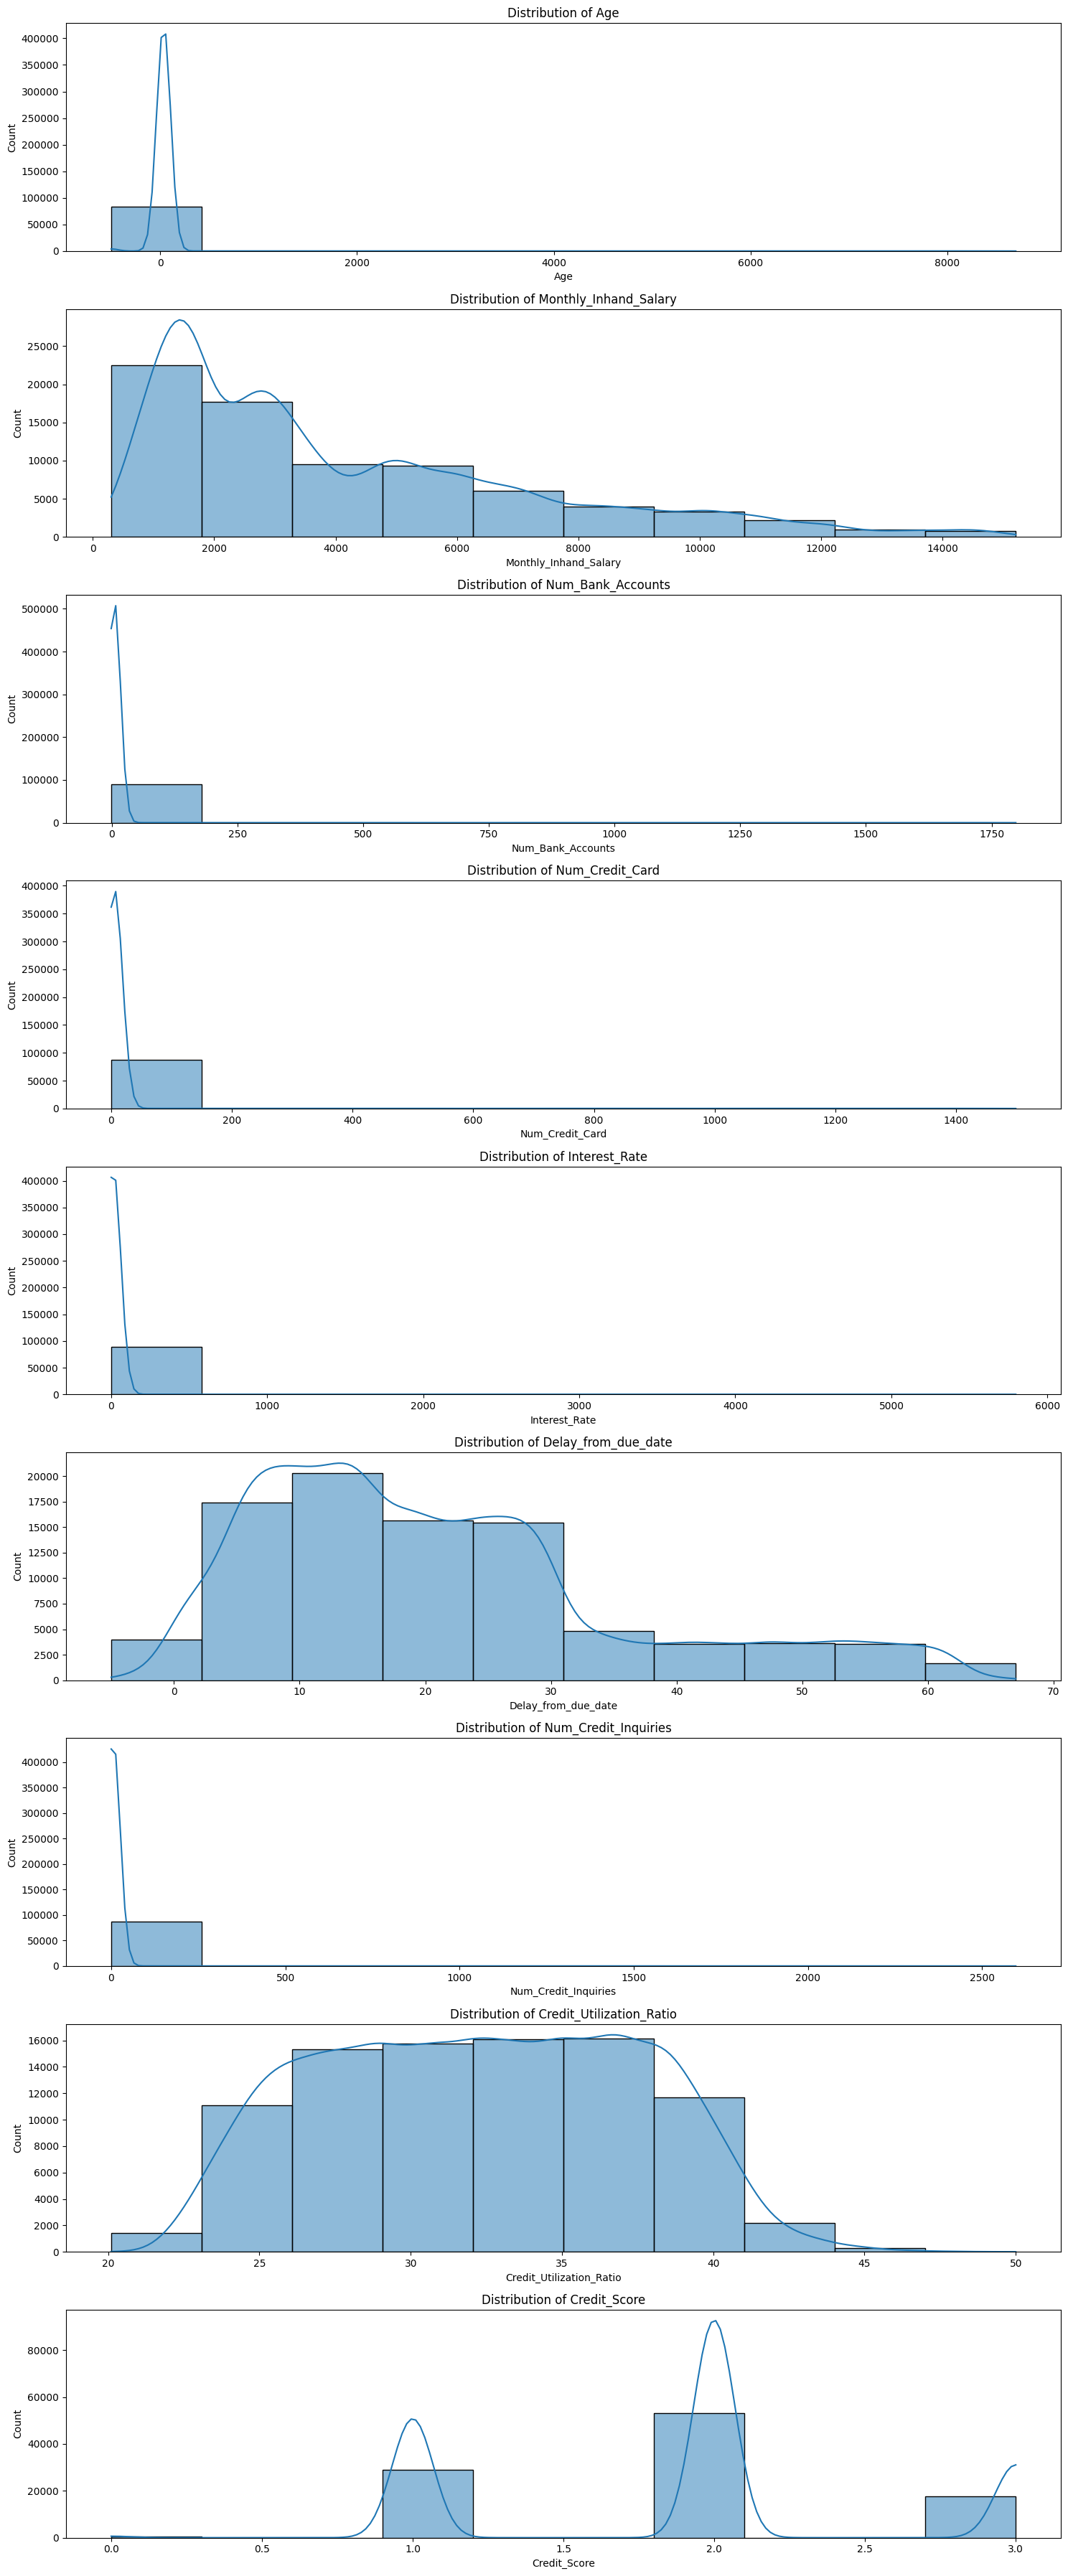

In [ ]:
# Loop through all numerical columns and plot their distributions : it does not work yet!!!!!
numeric_cols = credit_card_df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numeric_cols) * 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(credit_card_df[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()